# Customize YOLO11 for sign language object detection and deploy to SageMaker Endpoint

This notebook will use the latest YOLO11 (at the moment of writing this ) model to identify sign language. It will be trained on the custom dataset created by the author. 
The classes that we will identify are: ['hello', 'love', 'me', 'mother', 'no', 'please', 'thankyou', 'yes', 'you', 'your']
First of all, we will check what the version of CUDA is.

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


We need it to identify proper dependencies to install. After we see the version of CUDA, go to https://pytorch.org/get-started/locally/. and check for proper dependencies

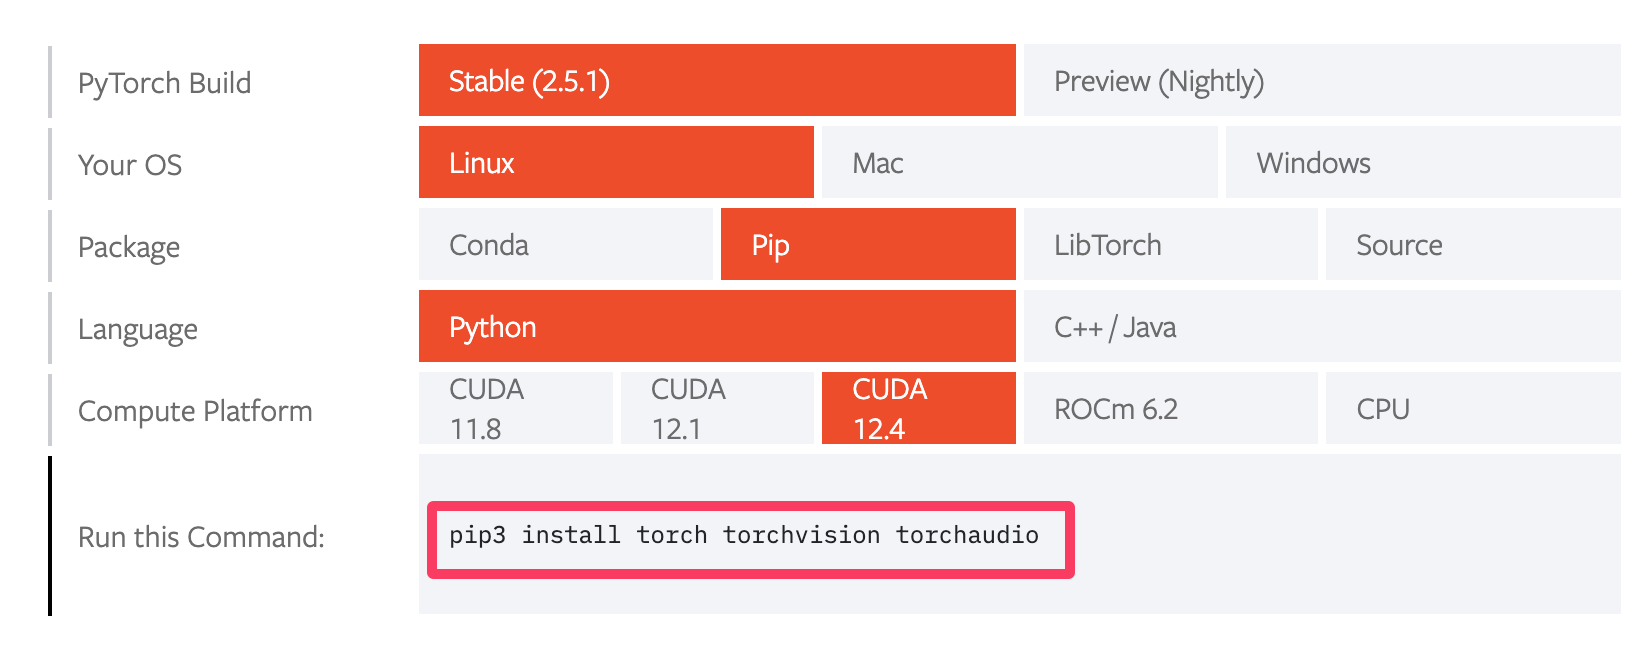

Next, we run it

In [ ]:
!pip3 install --upgrade torch torchvision torchaudio ultralytics

Now we need to download the base model from https://github.com/ultralytics/ultralytics. There are several model sizes, and this example uses the largest one.

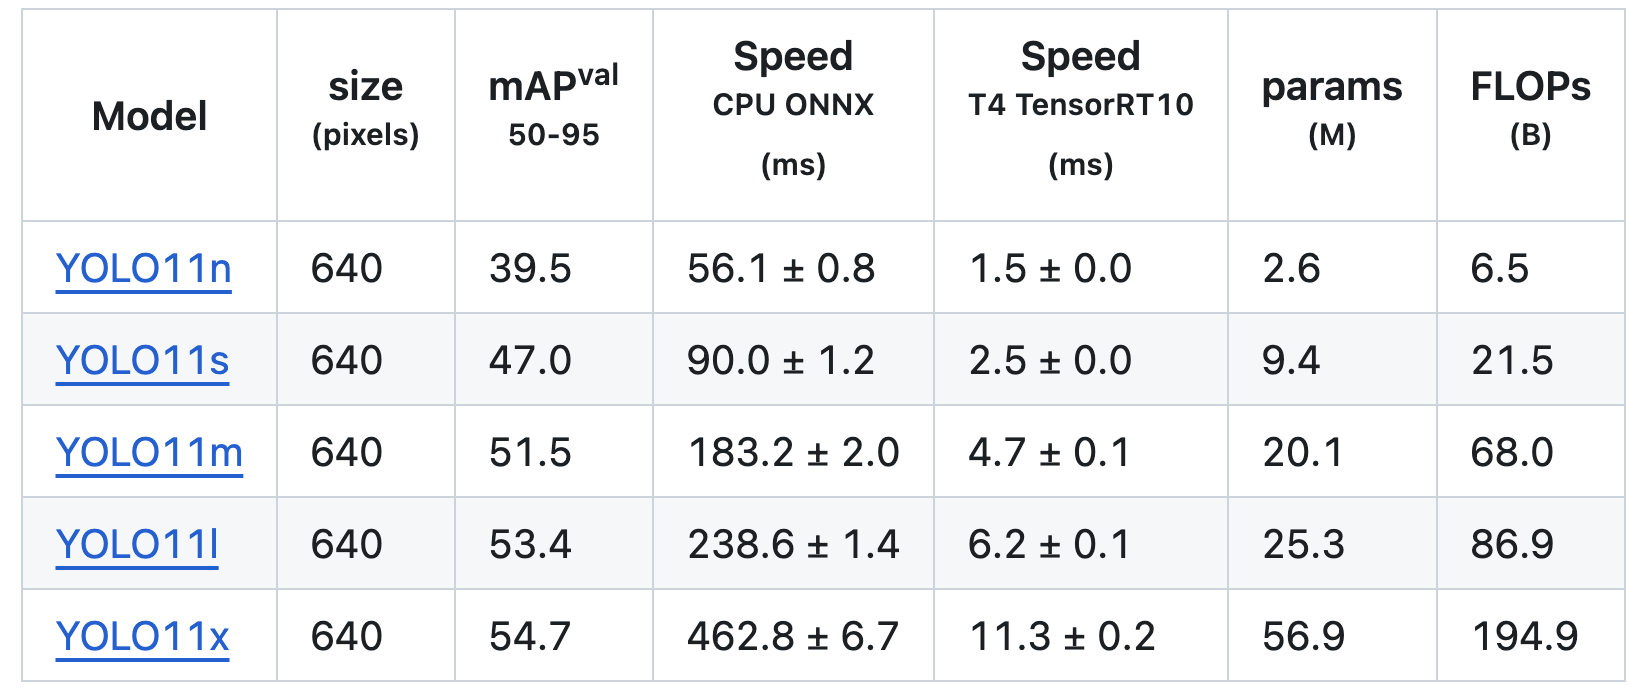

In [ ]:
!wget https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11x.pt

This command may NOT be necessary. But after I ran the training for the first time, the process failed with some missing C library. Running this command fixed the problem.

In [ ]:
!sudo apt-get install -y libgl1-mesa-glx


Next, you need to create the dataset. I used the Roboflow - https://roboflow.com/  annotation tool (free sign-up required). You actually can use any annotation tool, and the major reason why I used Roboflow is because it allows you to download the dataset in a format that YOLO expects. 

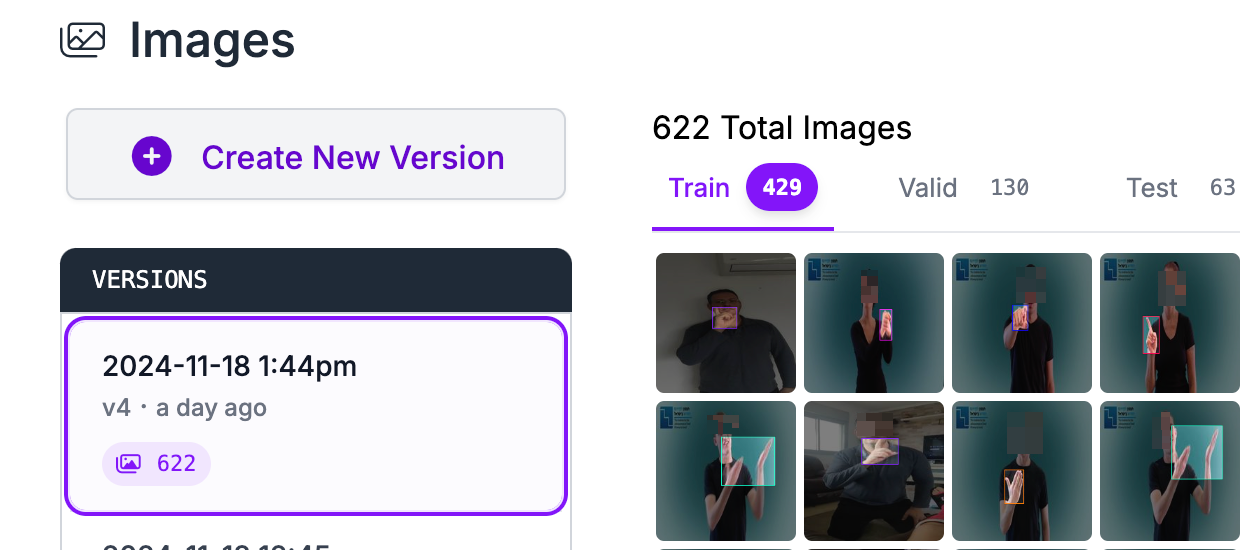

"love" sign
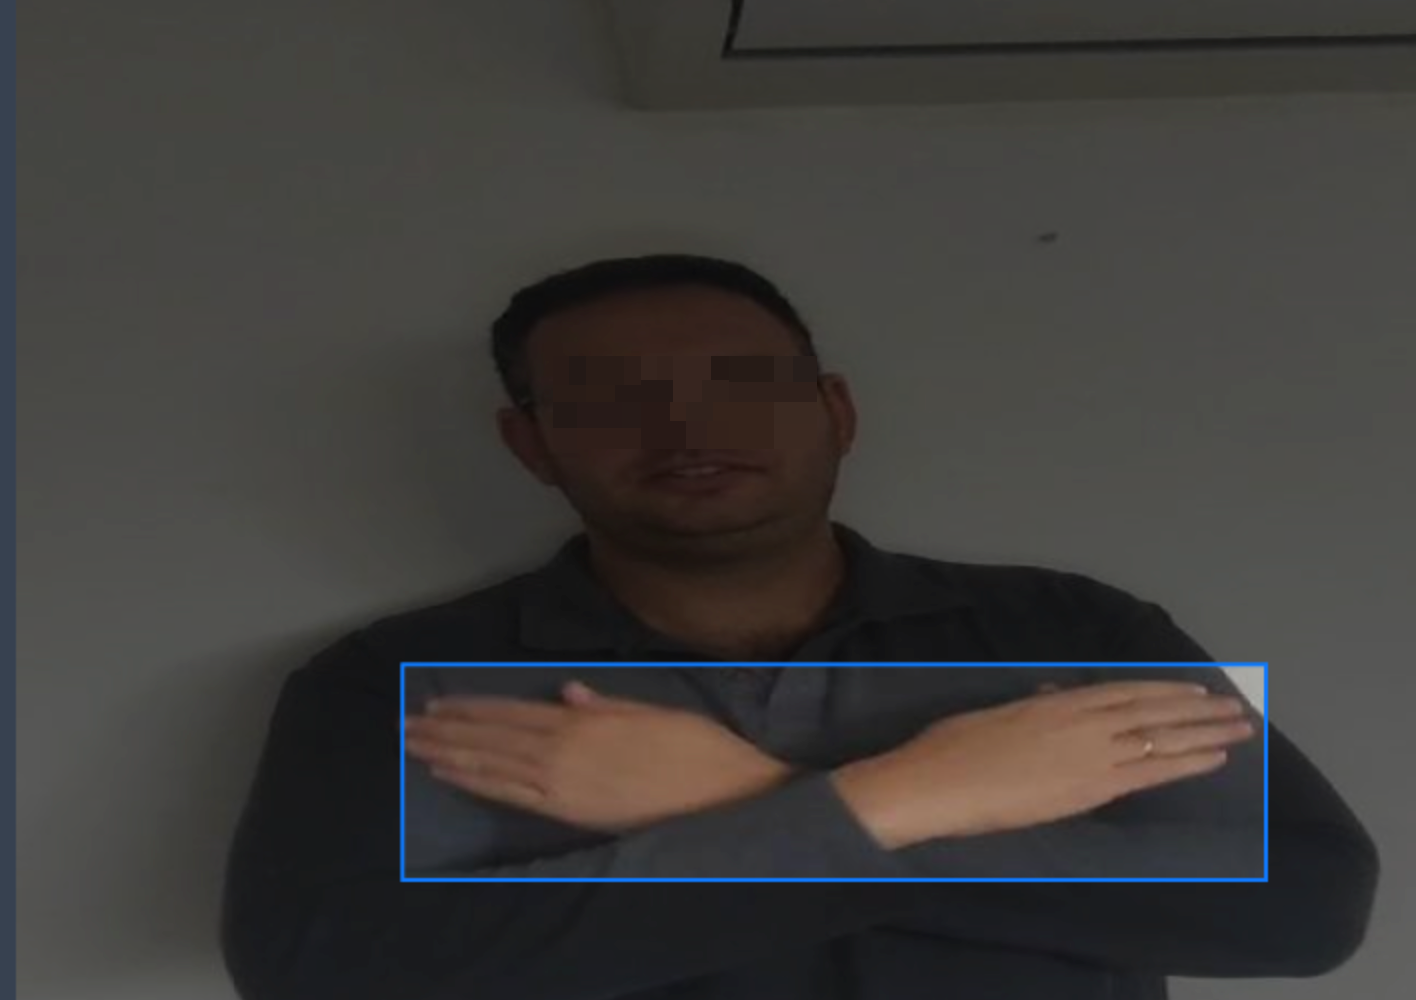

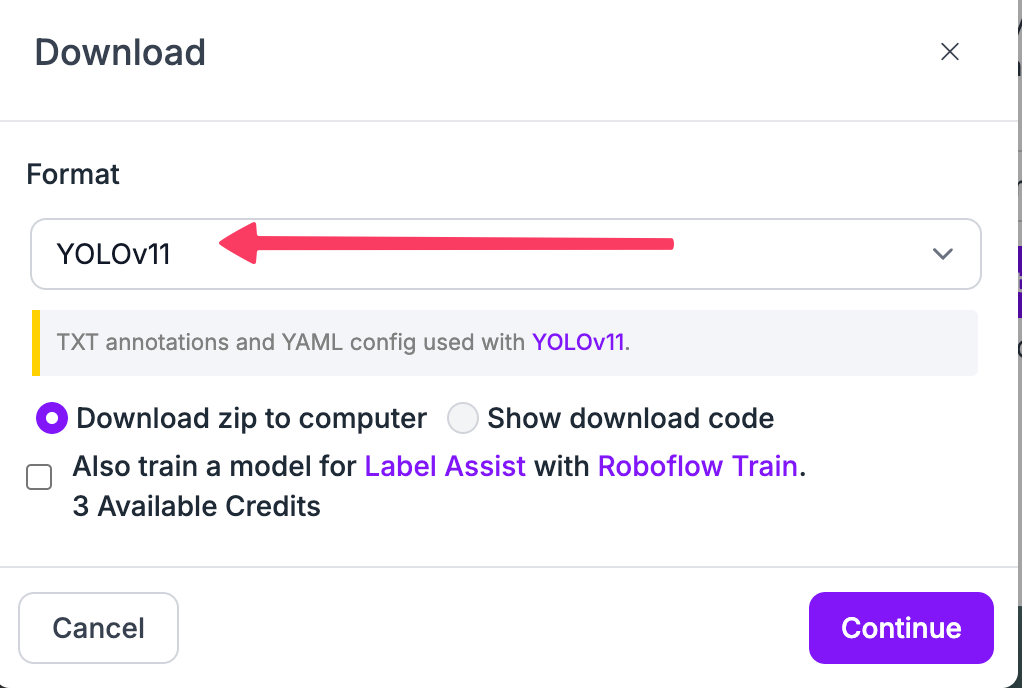

Your folders should look like this after you extract the files from Roboflow and download YOLO model

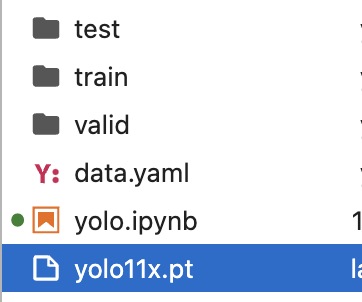

The code to train is very simple. Note that we trained on a GPU, and the memory consumption is somewhere around 17GB. So you need to choose relevant instance.

In [5]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11x.pt")

# Train the model (I used ml.g5.xlarge instance)

train_results = model.train(
    data="data.yaml",  # path to dataset YAML
    epochs=100,  # number of training epochs
    imgsz=640,  # training image size
    device=0,  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/sagemaker-user/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.34 🚀 Python-3.11.10 torch-2.5.1+cu124 CUDA:0 (NVIDIA A10G, 22503MiB)
engine/trainer: task=detect, mode=train, model=yolo11x.pt, data=data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=3

100%|██████████| 755k/755k [00:00<00:00, 73.5MB/s]


Overriding model.yaml nc=80 with nc=11

                   from  n    params  module                                       arguments                     
  0                  -1  1      2784  ultralytics.nn.modules.conv.Conv             [3, 96, 3, 2]                 
  1                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  2                  -1  2    389760  ultralytics.nn.modules.block.C3k2            [192, 384, 2, True, 0.25]     
  3                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
  4                  -1  2   1553664  ultralytics.nn.modules.block.C3k2            [384, 768, 2, True, 0.25]     
  5                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              
  6                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  7                  -1  1   5309952  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 268MB/s]


AMP: checks passed ✅


train: Scanning /home/sagemaker-user/yolo/train/labels... 456 images, 18 backgrounds, 0 corrupt: 100%|██████████| 456/456 [00:00<00:00, 1136.36it/s]


train: New cache created: /home/sagemaker-user/yolo/train/labels.cache


val: Scanning /home/sagemaker-user/yolo/valid/labels... 137 images, 6 backgrounds, 0 corrupt: 100%|██████████| 137/137 [00:00<00:00, 1129.20it/s]

val: New cache created: /home/sagemaker-user/yolo/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)


2024/11/20 10:06:03 INFO mlflow.tracking.fluent: Experiment with name '/Shared/Ultralytics' does not exist. Creating a new experiment.
2024/11/20 10:06:03 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2024/11/20 10:06:03 WARNING mlflow.utils.autologging_utils: MLflow keras autologging is known to be compatible with 3.0.2 <= keras <= 3.5.0, but the installed version is 3.6.0. If you encounter errors during autologging, try upgrading / downgrading keras to a compatible version, or try upgrading MLflow.
2024/11/20 10:06:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2024/11/20 10:06:03 WARNING mlflow.utils.autologging_utils: MLflow statsmodels autologging is known to be compatible with 0.11.1 <= statsmodels <= 0.14.3, but the installed version is 0.14.4. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a compatible version, or try upgrading ML

MLflow: logging run_id(0484a0e88bfe464082216da67dd55a2a) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      17.2G      1.674      4.297      1.922          8        640: 100%|██████████| 29/29 [00:15<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]

                   all        137        131      0.666      0.291      0.373      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      17.1G      1.475      2.712      1.738          9        640: 100%|██████████| 29/29 [00:15<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]

                   all        137        131      0.599      0.337      0.297      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      17.3G      1.462      2.377      1.689         13        640: 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]

                   all        137        131      0.277      0.137     0.0701     0.0196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      17.3G      1.517      2.154      1.682          7        640: 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        137        131      0.388      0.133      0.121     0.0482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      17.1G      1.413      1.692      1.596         17        640: 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]

                   all        137        131      0.326      0.449      0.432      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      17.3G      1.469      1.687      1.618         10        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        137        131      0.705      0.168      0.122     0.0666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      17.3G      1.451       1.57      1.659         12        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        137        131      0.553      0.721      0.595       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      17.3G      1.336      1.419      1.519         12        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        137        131      0.231     0.0291     0.0258     0.0126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      17.1G       1.46      1.392      1.574         19        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        137        131      0.304      0.269      0.257      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      17.3G      1.323      1.217      1.493          8        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]

                   all        137        131      0.683      0.571      0.715      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      17.3G      1.308      1.252      1.487         13        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        137        131      0.776      0.664      0.879      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      17.3G      1.247      1.107      1.441         12        640: 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        137        131      0.724        0.8      0.865      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      17.1G       1.27      1.082      1.449         13        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        137        131       0.75      0.703      0.836      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      17.3G      1.296      1.103      1.461         20        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        137        131       0.86      0.814      0.911       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      17.3G      1.151      1.015      1.377         10        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        137        131       0.78      0.912      0.871      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      17.2G       1.17      1.006      1.386          9        640: 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        137        131      0.833      0.804      0.871      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      17.1G       1.23          1      1.447          9        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        137        131      0.824      0.894      0.925      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      17.3G      1.175     0.9387      1.404         11        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        137        131        0.9      0.761      0.886      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      17.3G      1.159     0.9097      1.378         19        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        137        131      0.961      0.925      0.974      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      17.3G      1.142     0.9082      1.382         13        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        137        131        0.9      0.916      0.979      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      17.1G      1.113     0.8431      1.354         11        640: 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.903      0.955      0.966      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      17.3G      1.188      0.932      1.399         13        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        137        131       0.89      0.882      0.958      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      17.3G      1.134     0.8614       1.36         11        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        137        131      0.904      0.896      0.952       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      17.3G      1.143     0.8079       1.37          9        640: 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        137        131      0.893      0.899      0.958      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      17.1G      1.152     0.8408      1.388          6        640: 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        137        131      0.943       0.94      0.975      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      17.3G      1.133      0.811      1.365         13        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        137        131      0.876       0.95      0.972      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      17.3G       1.08     0.7615      1.305         15        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        137        131      0.892      0.931      0.966      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      17.3G      1.125     0.8153      1.363         16        640: 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.858      0.958      0.985      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      17.1G      1.054     0.8005      1.316         17        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        137        131      0.923      0.955      0.978      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      17.3G      1.037     0.7549      1.289         13        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        137        131      0.936      0.967      0.986       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      17.3G      1.036     0.7325      1.293         14        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.923       0.98      0.977      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      17.3G      1.025     0.7461        1.3         17        640: 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.933      0.958      0.994      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      17.1G      1.061     0.7287      1.309         10        640: 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        137        131      0.926      0.952      0.976      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      17.3G      1.049     0.7032      1.301         10        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.951       0.97       0.99      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      17.3G      1.043       0.71      1.287         15        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.959      0.936      0.969      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      17.3G     0.9978     0.6834      1.264         12        640: 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        137        131      0.869      0.972      0.984      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      17.1G      1.012     0.6859      1.278         22        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.953      0.942      0.992      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      17.3G      1.038     0.7007      1.291         17        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.966      0.966      0.986      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      17.3G      1.061      0.694      1.305         13        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.972      0.964       0.99      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      17.3G      1.031     0.6676      1.312          7        640: 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131       0.94      0.967      0.987      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      17.1G      1.007     0.6872      1.275         11        640: 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.956      0.942      0.986       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      17.3G      1.023     0.6539      1.298         10        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.956      0.957      0.989      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      17.3G      1.017     0.6626      1.266         15        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.941      0.975      0.985      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      17.3G      1.007     0.6517      1.279          8        640: 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.957      0.956      0.988      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      17.1G     0.9965     0.6379       1.26          6        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        137        131      0.946      0.973      0.992      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      17.3G      1.001     0.6506      1.287         12        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        137        131      0.972      0.972      0.978      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      17.3G     0.9655     0.6181      1.232         18        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        137        131      0.949      0.972      0.991      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      17.3G     0.9507     0.6081      1.244         16        640: 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.978      0.984      0.994      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      17.1G     0.9828      0.599       1.24         11        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.972      0.965      0.993      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      17.3G     0.9941     0.6211      1.257         13        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.936      0.977      0.992       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      17.3G     0.9965     0.5763      1.254         14        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131       0.96      0.967      0.983      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      17.3G     0.9491     0.5852      1.227         10        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.965      0.979      0.989      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      17.1G     0.9586     0.5876      1.258          9        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.972      0.983      0.994      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      17.3G     0.9485     0.6099      1.214         11        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.952       0.99      0.992      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      17.3G     0.9589     0.5806      1.212         20        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.959      0.986      0.993       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      17.3G     0.9428       0.58      1.238         11        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.964      0.977      0.989      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      17.1G     0.9333     0.5485      1.215          9        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.959      0.972      0.988      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      17.3G     0.8959     0.5447      1.201          9        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.952      0.976      0.986      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      17.3G     0.9172     0.5509      1.212          9        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.975      0.967      0.991      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      17.3G     0.9124     0.5382      1.201         15        640: 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.971      0.978      0.994      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      17.1G     0.9188     0.5523      1.207         12        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.976      0.976       0.99      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      17.3G     0.9176     0.5476      1.225          7        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.955      0.976      0.993      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      17.3G     0.9015      0.529        1.2         16        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.971      0.978      0.994      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      17.3G     0.8912     0.5495      1.195         16        640: 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.981      0.961      0.995      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      17.1G     0.8997     0.5325      1.197          8        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        137        131      0.957      0.985      0.994      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      17.3G     0.8905      0.541      1.196         12        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.977      0.986      0.995      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      17.3G     0.8846     0.4846      1.172          9        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.977       0.99      0.994      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      17.3G     0.8688      0.511      1.175         12        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.977      0.974      0.992      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      17.1G      0.878     0.5038       1.18         10        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.979      0.975      0.994      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      17.3G      0.893     0.4971      1.199         13        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        137        131      0.971      0.985      0.993      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      17.3G     0.8967     0.5102      1.194         14        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        137        131      0.969      0.986      0.994      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      17.3G     0.8937     0.4957      1.185         13        640: 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        137        131      0.975      0.989       0.99      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      17.1G     0.8724     0.4999      1.185          8        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        137        131      0.975      0.988      0.994       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      17.3G     0.8659     0.4832      1.178         18        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.971      0.985      0.992      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      17.3G     0.8404     0.4931      1.151         17        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.959      0.977      0.992      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      17.3G     0.8763      0.502      1.154         15        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        137        131      0.952      0.992      0.993       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      17.1G     0.8451     0.4736      1.159         13        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        137        131      0.969      0.992      0.994      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      17.3G     0.8602     0.4731      1.177         12        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        137        131      0.964       0.99      0.994      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      17.3G     0.8517     0.4757      1.159         12        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.969      0.995      0.995      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      17.3G      0.817     0.4847      1.161         16        640: 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        137        131      0.974      0.992      0.995      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      17.1G     0.8472     0.4841      1.151         14        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.975      0.995      0.995      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      17.3G     0.8344     0.4628      1.148         10        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        137        131      0.979      0.993      0.995      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      17.3G     0.8193     0.4418       1.14         19        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        137        131      0.973       0.99      0.994       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      17.3G     0.8084     0.4407      1.139         13        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        137        131       0.98      0.993      0.995      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      17.1G     0.8047     0.4279       1.14         10        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.971      0.991      0.995      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      17.3G     0.8554     0.4678      1.156         14        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        137        131      0.968      0.979      0.993      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      17.3G     0.8327     0.4578      1.145         10        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        137        131      0.972      0.981      0.994      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      17.3G     0.8168     0.4363      1.134         14        640: 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.982      0.982      0.994       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      17.1G     0.7949     0.4224      1.125         10        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        137        131      0.978      0.988      0.994       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      17.3G     0.8126     0.4359      1.149          7        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        137        131       0.98      0.984      0.994      0.742


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      17.3G     0.7498     0.3494      1.172          7        640: 100%|██████████| 29/29 [00:15<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.971      0.988      0.994      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      17.3G     0.7465     0.3425      1.182          8        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        137        131      0.974      0.993      0.995      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      17.1G      0.731     0.3366      1.154          8        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        137        131      0.979      0.993      0.995      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      17.3G     0.7357     0.3391      1.154          7        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        137        131      0.981      0.994      0.995      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      17.3G     0.7108     0.3324      1.136          7        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        137        131      0.978      0.994      0.995      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      17.3G     0.7218     0.3302      1.139          7        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        137        131      0.976      0.994      0.995      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      17.1G     0.7158     0.3306      1.147          7        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        137        131      0.976      0.996      0.995      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      17.3G     0.7151      0.328      1.152          8        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        137        131      0.977      0.996      0.995      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      17.3G     0.7023     0.3214      1.142          7        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        137        131      0.977      0.997      0.995      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      17.3G     0.6968     0.3162      1.135          7        640: 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        137        131      0.976      0.997      0.995      0.754



100 epochs completed in 0.565 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 114.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 114.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.11.10 torch-2.5.1+cu124 CUDA:0 (NVIDIA A10G, 22503MiB)
YOLO11x summary (fused): 464 layers, 56,839,729 parameters, 0 gradients, 194.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


                   all        137        131       0.98      0.993      0.995      0.775
                  food          7          7      0.992          1      0.995      0.822
                 hello         16         16      0.992          1      0.995      0.739
                  love         20         20      0.989          1      0.995      0.802
                    me         11         11          1      0.922      0.995       0.73
                mother         28         28      0.997          1      0.995      0.776
                    no          9          9      0.982          1      0.995      0.779
                please          4          4       0.97          1      0.995      0.798
              thankyou          9          9      0.894          1      0.995      0.768
                   yes          4          4      0.975          1      0.995       0.67
                   you         18         18      0.992          1      0.995      0.817
                  you

You can find the best model in this directory. It appears at the end of the training process. I renamed it to **yolo11x_custom.pt**
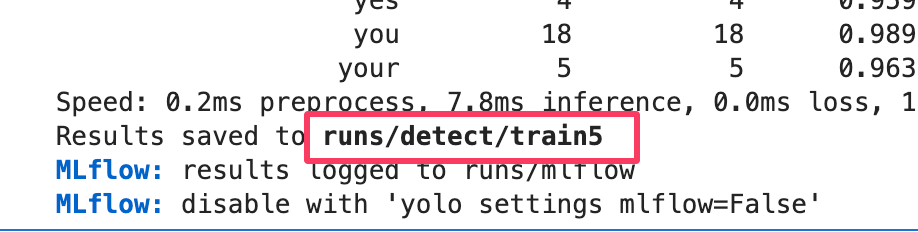

In [2]:
#Dispay validation metrics for each class
metrics = model.val()

Ultralytics 8.3.32 🚀 Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (Tesla V100-SXM2-32GB, 32494MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


val: Scanning /home/sagemaker-user/yolo/valid/labels.cache... 39 images, 1 backgrounds, 0 corrupt: 100%|██████████| 39/39 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


                   all         39         38      0.983          1      0.995      0.734
                    me          6          6          1          1      0.995      0.681
                mother          6          6      0.976          1      0.995      0.703
                    no          9          9      0.982          1      0.995      0.744
                please          4          4      0.974          1      0.995      0.802
              thankyou          9          9      0.983          1      0.995      0.733
                   yes          4          4      0.985          1      0.995      0.742
Speed: 0.3ms preprocess, 11.7ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train2


For deployment to Sagemaker I created the following folder structure (see the printscreen).
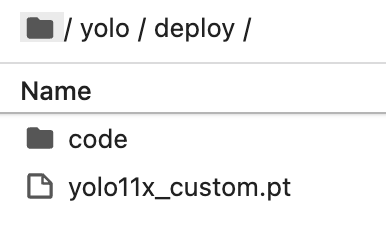

We will discuss later why do we need it

In [7]:
#now we will load the trained model
from ultralytics import YOLO
model_custom = YOLO("deploy/yolo11x_custom.pt")
model_custom.info()

YOLO11x summary: 631 layers, 56,886,481 parameters, 0 gradients, 195.5 GFLOPs


(631, 56886481, 0, 195.5136)

In [ ]:
# We will use one of the validation images (it was not used for training) to check the results. 
# You validation image probably will have a different name
# Note the "save" parameter. 
VALIDATION_IMAGE='valid/images/me000040_jpg.rf.c17bb94aafb9977099e35ec30076fbb5.jpg'

response = model_custom.predict(source=VALIDATION_IMAGE,show=False,save=True,conf=0.25,line_width=1)
response

Since we put "save=True" we can find the output image in this directory
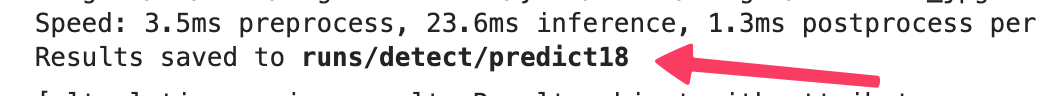

And here is the output, which looks good

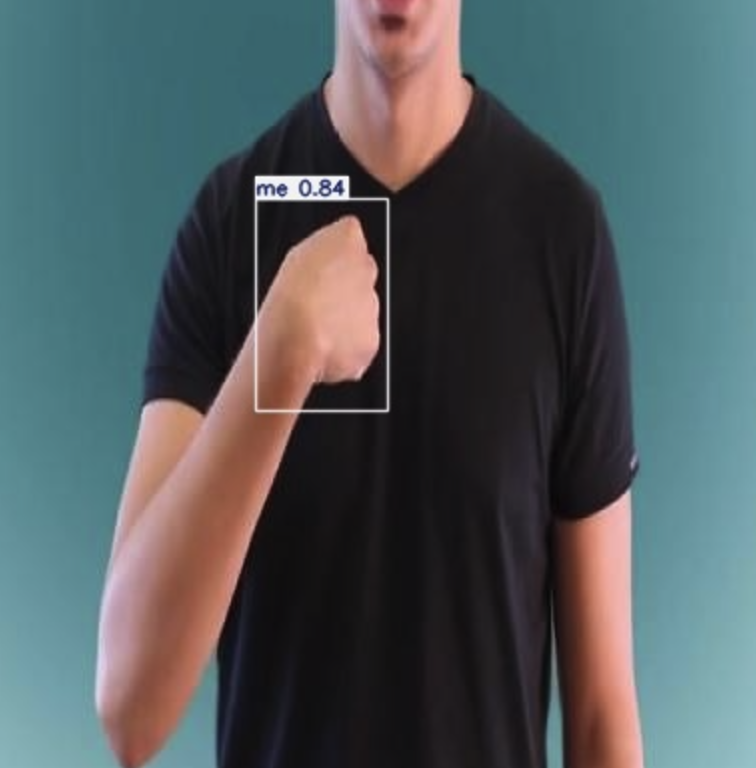

In [12]:
# this is generic code to read the output from the model
#  we focused on object detection, but the model can do also other things
# like segmentation
import json

infer = {}
for result in response:
    if result.boxes:
        infer['boxes'] = result.boxes.cpu().numpy().data.tolist()
    if result.masks:
        infer['masks'] = result.masks.cpu().numpy().data.tolist()
    if result.probs:
        infer['probs'] = result.probs.cpu().numpy().data.tolist()
j_result=json.dumps(infer)

In [13]:
#to get predicted class, run the following code
predictions = json.loads(j_result)
model_custom.names.get(predictions["boxes"][0][-1])
       

'me'

In order to host the model on SageMaker, you need to have very specific steps. They are described here: https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html (check Model Directory Structure).

But in short, you need to have inference.py and requirements.txt files in the code directory and the model file in parallel to the code directory. You can find both files in deploy/code directory.
The code folder and the model should be ziped into model.tar.gz file and uploaded to S3


To create the gz file run "tar -czvf model.tar.gz code/ yolo11x_custom.pt" from deploy directory

In [42]:
# now upload the model to S3. You need to make sure that you have proper permissions to work with S3 bucket
from sagemaker import s3
#change to your bucket
bucket = "s3://yolo11-michshap"
prefix = "yolov11/demo-custom-endpoint"
model_data = s3.S3Uploader.upload("deploy/model.tar.gz", bucket + "/" + prefix)
model_data

's3://yolo11-michshap/yolov11/demo-custom-endpoint/model.tar.gz'

In [43]:
from sagemaker.pytorch import PyTorchModel
from sagemaker import get_execution_role
import sagemaker

model_name = 'yolo11x_custom.pt'

role = get_execution_role()
session = sagemaker.Session()

#I used prebuild image for SageMaker with Pytorch and GPU.
#You can find relevant image here: https://github.com/aws/deep-learning-containers/blob/master/available_images.md
#Note that the one I use is for "us-east-1" region

model = PyTorchModel(entry_point='inference.py',
                     model_data=model_data,
                     image_uri='763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:2.5.1-gpu-py311-cu124-ubuntu22.04-sagemaker',
                     role=role,
                     env={'TS_MAX_RESPONSE_SIZE':'20000000', 'YOLOV11_MODEL': model_name},
                     sagemaker_session=session)




In [44]:
from sagemaker.deserializers import JSONDeserializer

# I choose g5 instance since it has A10G GPU card.
# Could be that less powerfull instance can be used, but you have to check it by yourself :). 

INSTANCE_TYPE = 'ml.g5.2xlarge'
ENDPOINT_NAME = 'yolov11-custom-sign-language'

predictor = model.deploy(initial_instance_count=1,
                         instance_type=INSTANCE_TYPE,
                         deserializer=JSONDeserializer(),
                         endpoint_name=ENDPOINT_NAME)

-------------!

In [45]:
import boto3
import numpy as np
import json
import io
import cv2

#By default, the endpoint input serializer expects bytes, so we convert the image to bytes.
#Inside inference.py file we convert it back to image object

# Load the image. It is the same one we used by directly calling "predict" on the model_custom object

image_path = VALIDATION_IMAGE  # Change this to your image file
image = cv2.imread(image_path)
_, img_bytes = cv2.imencode('.jpg', image)

# Convert the memory buffer to bytes
image_bytes = img_bytes.tobytes()

# Create a SageMaker runtime client
runtime_client = boto3.client('sagemaker-runtime')

# Invoke the endpoint
response = runtime_client.invoke_endpoint(
    EndpointName=ENDPOINT_NAME,
    ContentType='application/x-image',
    Body=image_bytes
)

# Process the response
result = response['Body'].read()
predictions = json.loads(result)
print(predictions)

{'boxes': [[280.300048828125, 333.251708984375, 345.956787109375, 436.8214111328125, 0.8167926073074341, 3.0]]}


In [46]:
model_custom.names.get(predictions["boxes"][0][-1])

'me'

In [38]:
#Cleanup
import boto3

sm_client = boto3.client(service_name="sagemaker")

response = sm_client.describe_endpoint_config(EndpointConfigName=ENDPOINT_NAME)
print(response)

{'EndpointConfigName': 'yolov11-custom-sign-language', 'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:346399954218:endpoint-config/yolov11-custom-sign-language', 'ProductionVariants': [{'VariantName': 'AllTraffic', 'ModelName': 'pytorch-inference-2024-11-20-12-16-14-001', 'InitialInstanceCount': 1, 'InstanceType': 'ml.g5.xlarge', 'InitialVariantWeight': 1.0}], 'CreationTime': datetime.datetime(2024, 11, 20, 12, 16, 15, 113000, tzinfo=tzlocal()), 'EnableNetworkIsolation': False, 'ResponseMetadata': {'RequestId': 'f9970e96-8722-42cb-a121-db251a410fca', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'f9970e96-8722-42cb-a121-db251a410fca', 'content-type': 'application/x-amz-json-1.1', 'content-length': '414', 'date': 'Wed, 20 Nov 2024 12:47:09 GMT'}, 'RetryAttempts': 0}}


In [39]:
endpoint_config_name = response['EndpointConfigName']

# Delete Endpoint
sm_client.delete_endpoint(EndpointName=ENDPOINT_NAME)

{'ResponseMetadata': {'RequestId': '84edae87-657c-40cf-834d-6cbf1fa8a2af',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '84edae87-657c-40cf-834d-6cbf1fa8a2af',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 20 Nov 2024 12:47:12 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}

In [40]:
# Delete Endpoint Configuration
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

{'ResponseMetadata': {'RequestId': '243fa8e3-d522-4812-a9b8-c987efe499c5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '243fa8e3-d522-4812-a9b8-c987efe499c5',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 20 Nov 2024 12:47:16 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}

In [41]:
# Delete Model
for prod_var in response['ProductionVariants']:
    model_name = prod_var['ModelName']
    sm_client.delete_model(ModelName=model_name)